# Automatic Salt Body Interpretation with CNN: Training & Prediction

Author: Yu (Jason) Zeng  &nbsp; &nbsp;| &nbsp; &nbsp; Email: yu.zeng.duke@gmail.com &nbsp; &nbsp; | &nbsp; &nbsp; Date: Feb. 08, 2019

This notebook contains sample codes to build and train convolutional neural networks for our paper **Automatic Seismic Salt Interpretation with Deep Convolutional Neural Networks** ([arxiv:1802.01101](https://arxiv.org/abs/1812.01101)) (co-authors: Kebei Jiang and Jie Chen). This paper has been accepted by *The 3rd International Conference on Information System and Data Mining* ([ICISDM 2019](http://icisdm.org/)). 

For demonstration purpose only, I trained 40 epochs in this notebook to show  our working flow and basic ideas.

Key steps for this Machine Learning project:
-  [1. Introduction](#cell_0)


-  [2. Input data preparation](./salt_body_segyin_data_prep.ipynb) (discussed in a separate notebook)
    * 2.1 SEGY file read-in
    * 2.2 Raw data QC and data transformation
    * 2.3 Data cropping into small pieces (101x101) 
    * 2.4 Save cropped pieces as inputs for CNN test
    * 2.5 Read-back QC
    
    
-  [3. Data Loading and QC](#cell_2)
    * [3.1 Load training data from earlier preparation](#cell_2_1)
    * [3.2 Classify salt mask types based on coverage](#cell_2_2)
    
    
-  [4. Network](#cell_3)
    * [4.1 Network architecture](#cell_3_1)
    * [4.2 Evaluate metrics](#cell_3_2)
    * [4.3 Network training considerations: stratified K-fold](#cell_3_3)
    * [4.4 Construction of U-Net + ResNet Networks](#cell_3_4)
    * [4.5 Lovasz hinge Jaccard loss](#cell_3_5)
    
    
-  [5. Network Training](#cell_4)
    * [5.1 Learning rate scheduling](#cell_4_1)
    * [5.2 First round of training:](#cell_4_2) $\eta_1=0.001$ with Cross Entropy as loss (20 epoch)
    * [5.3 Second round of training:](#cell_4_3) $\eta_2=0.0005$ with Lovasz hinge as loss (10 epoch)
    * [5.4 Third round of training:](#cell_4_4) $\eta_3=0.0001$ with Lavasz hinge as loss (10 epoch)
    
    
-  [6. Result](#cell_5)
    * [6.1 Load test seismic images](#cell_5_1)
    * [6.2 Save prediction results as numpy array](#cell_5_2)
    * [6.3 Read back predictions and combine](#cell_5_3)
    * [6.4 Overlay with block information and compare with true labels](#cell_5_4)
    
    
-  [7. Discussion](#cell_6)


-  [8. Conclusion](#cell_7)


-  [9. Appendix](#cell_8)
    * [A. Model summary](#cell_8a)
    * [B. ELU vs. ReLU](#cell_8b)


-  [10. References](#cell_9)

## 1. Introduction <a id='cell_0'></a>

One of the most crucial tasks in seismic reflection imaging is to identify the salt bodies with high precision. Traditionally, this is accomplished by visually picking the salt/sediment boundaries, which requires a great amount of manual work and may introduce systematic bias. With recent progress of deep learning algorithm and growing computational power, a great deal of efforts have been made to replace human effort with machine power in salt body interpretation. 

Currently, the method of Convolutional neural networks (CNN) is revolutionizing the computer vision field and has been a hot topic in the image analysis. In this Machine Learning project, the benefits of CNN-based classification are demonstrated by using a state-of-art network structure U-Net, along with the residual learning framework ResNet, to delineate salt body with high precision. Network adjustments, including the Exponential Linear Units (ELU) activation function, the Lovász-Softmax loss function, and stratified K-fold cross-validation, have been deployed to further improve the prediction accuracy. 

The preliminary result using SEG Advanced Modeling (SEAM) data shows good agreement between the predicted salt body and manually interpreted salt body, especially in areas with weak reflections. This indicates the great potential of applying CNN for salt-related interpretations. 

First, let's import a few common modules

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# import keras modules to construct network architecture
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img,save_img

import time
t_start = time.time()

Using TensorFlow backend.


## 2. Data Preparation

Details for data preparation is summarized in a [different notebook](./salt_body_segyin_data_prep.ipynb).

## 3. Data Loading and QC <a id='cell_2'></a>

### 3.1 Load training data from earlier preparation <a id="cell_2_1"></a>

In [2]:
# Loading of training/testing ids
train_df = pd.read_excel("C:/Users/idrun/Documents/01_DataScience/03_Salt_paper/03_png/train_1113a.xlsx", index_col='id')
len(train_df)
# Loading seismic images & corresponding interpreted labels/masks
train_df["images"] = [np.array(load_img("C:/Users/idrun/Documents/01_DataScience/03_Salt_paper/03_png/tmp_new_1113/images/train/image_{}.png".format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("C:/Users/idrun/Documents/01_DataScience/03_Salt_paper/03_png/tmp_new_1113/labels/train/label_{}.png".format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

### 3.2 Classify salt mask types based on coverage <a id="cell_2_2"></a>

In [3]:
# define upsample in case needed
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

# define downsample in case needed
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# categorize salt mask type depending on salt coverage within the image 
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

# calcuate histogram coverage
def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

Create coverage class for later stratified sampling: 

In [4]:
# inputs are already in 101x101, no need further up-sampling or down-sampling
img_size_ori = 101
img_size_target = 101

# create additional column based on salt coverge
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)
train_df["coverage_class"] = train_df.masks.map(get_mask_type)

## 4. Networks <a id='cell_3'></a>

### 4.1 Network architecture <a id="cell_3_1"></a>

The U-Net structure, which combines a contracting/down-sampling path to extract context information and a symmetric expanding/up-sampling path to retrieve location information, has been used as our baseline architecture. To overcome the degradation problem with deep learning networks, a particular variant of U-Net is adopted in our experiments: the Deep Residual Learning or the ResNet. 

ResNet is constructed by adding an identity mapping shortcut on top of every few stacked layers. This will result in higher prediction precision due to the fact that it is easier to learn the mapping of the residual, which is close to zero, than to directly learn from the full input. 

A schematic view of network architecture used in our experiment is shown below:

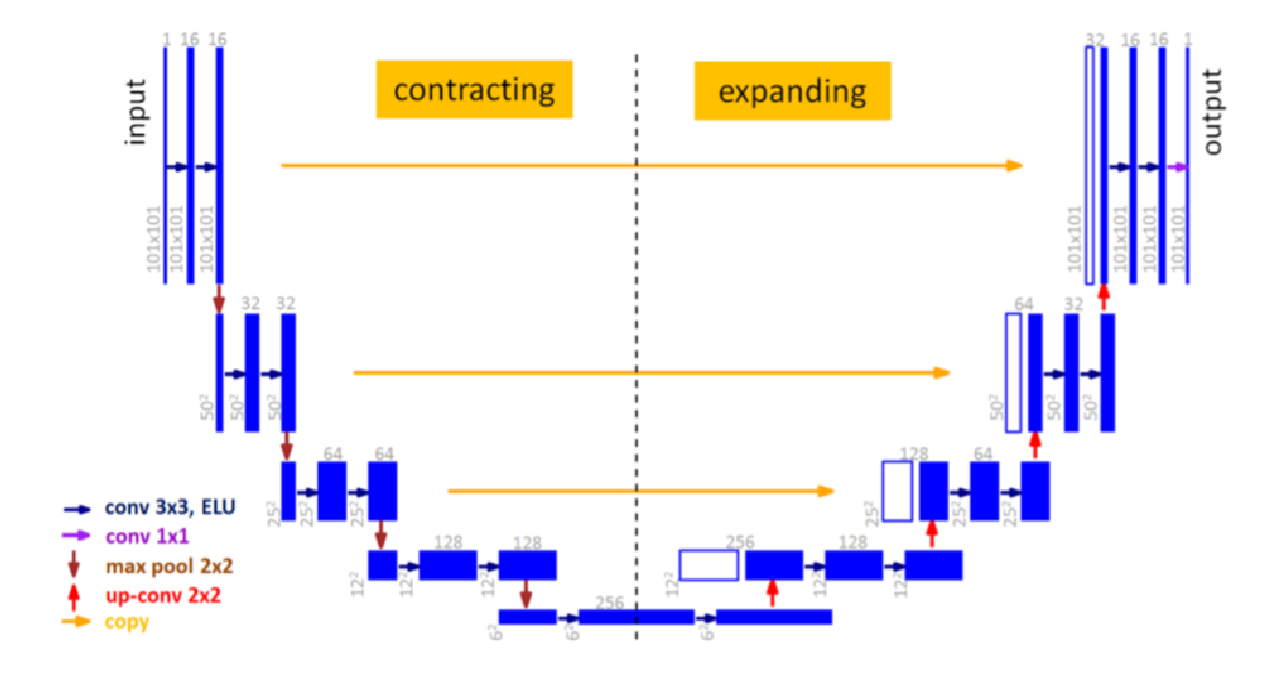

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("Unet.png")
plt.figure(figsize=(22,12))
plt.imshow(image, aspect='auto')
plt.axis("off")
plt.show()

### 4.2 Evaluation Metric <a id="cell_3_2"></a>

In our experimentation, the intersection-over-union (IoU) score, also known as Jaccard index, is used to quantify the performance of CNN salt prediction. IoU socre is the more widely accepted evaluation metric in the image segmentation. 
IoU measures the similarity between two or more definitive sample sets. Mathematically, it can be written as the intersection divied by the union of the sample sets:
<h1>
<center>
$J(A,B) = \frac{A\cap B}{ A\cup B}$
</center>
</h1>
This will generate a statistic between 0 and 1. Higher IoU score means better consistence between the predicted salt pixels and the ground truth sal mask.

In [6]:
# calculate IoU between A & B
def get_iou_vector(A, B):
    A = np.squeeze(A) # new added 
    B = np.squeeze(B) # new added
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0)  )/ (np.sum(union > 0) )
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

# use IoU as metric, for cross entropy, threshold=0.5
def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

# use IoU as metric, for Lovasz, change threshold to 0
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### 4.3 Network Training Considerations: Stratified K-fold <a id="cell_3_3"></a>

For neural networks, differences in random initialization, random mini-batch selection, and differences in hyperparameter space will tend to make prediction errors from different folds to be partially independent. The ensemble of the K models will, on average, perform better than its member models if the errors are not perfectly correlated. Below is a brief theoretical proof.

The exepcted variance of ensemble model will be:

$\mathbb{E}\left[\frac{1}{K}\left( \sum_{i} \delta_i  \right)^2\right] = 
    \frac{1}{K^2} \mathbb{E} \left[ \sum_{i} \left( \delta_i^2 + \sum_{j\ne i}\delta_i\delta_j \right) \right] = \frac{Var}{K} + \frac{(K-1)\cdot COV}{K}$ 

In the case where errors are independent, convariance $COV$ will be 0 and the above equation can be simplified as:

$\mathbb{E}\left[\frac{1}{K}\left( \sum_{i} \delta_i  \right)^2\right] = \frac{Var}{K}$

If however, the errors are perfectly correlated, variance and covariance will be identical and the equation will be simplied as:

$\mathbb{E}\left[\frac{1}{K}\left( \sum_{i} \delta_i  \right)^2\right] = Var$

If errors are partially correlated, the expected variance of ensemble model will be within the two extreme values:

$\frac{Var}{K} < E\left[\frac{1}{K}\left( \sum_i \delta_i  \right)^2\right] < Var $
    

Let's create stratified K-fold. During training, we will train on K-1 folds and make predictions and evaluations on the remaining 1 fold. The stratified K-fold sampling is performed to produce folds that contain a representative ratio of each class and is thus a better way to split training data. For this test, I will use K=5.



In [7]:
cv_total = 5   # 5-fold

train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=1234, shuffle=False) # set fixed random_state to get identical result
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

C:\Users\idrun\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


(490,) (126,)
(491,) (125,)
(493,) (123,)
(494,) (122,)
(496,) (120,)


Show some examples with different salt mask types, depending on coverage.

(490,) (126,)
train cv1, number of each mask class = 
 	[[ 97.  19. 316.   8.   3.   9.  16.  22.]]
histall:  (1, 8)
evaluate cv1, number of each mask class = 
 	 [[25.  5. 79.  3.  1.  3.  4.  6.]]


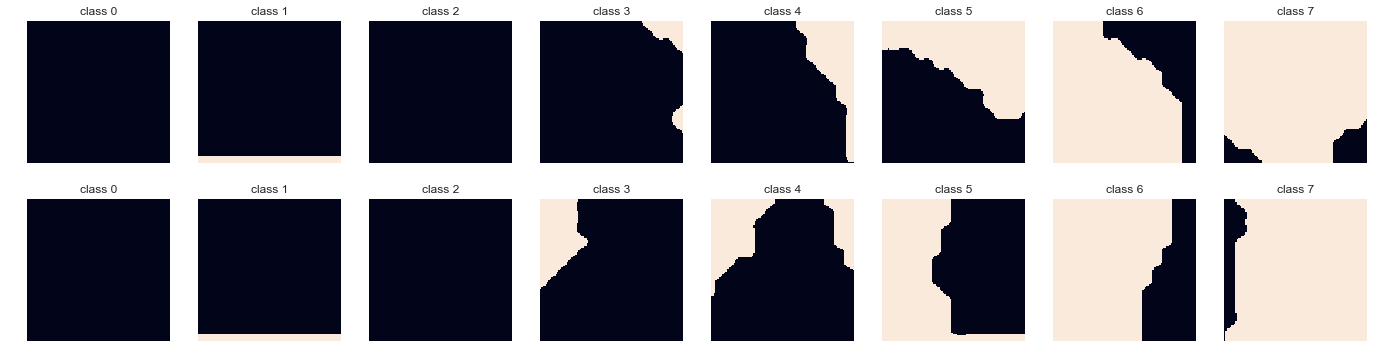

In [8]:
cv_index = 1   # check cv 1
train_index = train_all[cv_index-1]
evaluate_index = evaluate_all[cv_index-1]
print(train_index.shape,evaluate_index.shape)

histall = histcoverage(train_df.coverage_class[train_index].values)
print(f'train cv{cv_index}, number of each mask class = \n \t{histall}')

print('histall: ', histall.shape)
histall_test = histcoverage(train_df.coverage_class[evaluate_index].values)
print(f'evaluate cv{cv_index}, number of each mask class = \n \t {histall_test}')

n_qc_rows=2
n_qc_cols=histall.shape[1]
fig, axes = plt.subplots(nrows=n_qc_rows, ncols=n_qc_cols, figsize=(24, 6), sharex=True, sharey=True)

# show mask class example
for c in range(n_qc_cols):
    j= 0
    for i in train_index:
        if train_df.coverage_class[i] == c:
            axes[j,c].imshow(np.array(train_df.masks[i])  )
            axes[j,c].set_axis_off()
            axes[j,c].set_title(f'class {c}')
            j += 1
            if(j>=2):
                break

### 4.4 Construction of U-Net + ResNet Networks <a id="cell_3_4"></a>

Let's first build the residual block (ResNet) component. This ResNet component will be used as a building block when creating the U-Net architecture in a bigger scale.

In [9]:
# batch norm + activation with ReLU
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  # activation uses ReLU as default
    return x

# use stride=1 and same padding for convolution block,
# by default (activation=True), it will perform conv2d plus BatchNorm and Activation with ReLU
# if activation=False, it will only perform conv2d
def convolution_block(x, filters, kernal_size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, kernal_size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

# -----------------------------------------
# construct structures for Residual Block
def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) ) # kernal size=(3,3), with activation=True by default
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

Now, let's start building an U-Net structure. Within each U-net layer, two residual blocks are used. A long the U-Net path, the input dimension changes from: 

[101x101x1] --> [101x101x16] --> [50x50x32] --> [25x25x64] --> [12x12x128] --> [6x6x256] --> [12x12x128] --> [25x25x64] --> [50x50x32] --> [101x101x32] --> [101x101x1].

The information from layers in contracting path is transferred to the corresonding layer in the expanding path.

In [10]:
# ---------------------------------------------------------------------------
# Construct U-net architecture, given_input layer, then return output_layer
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    # concatenate deconv4 & conv4 to transfer information from contracting path to expansive path
    uconv4 = concatenate([deconv4, conv4])   
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# -------------------------------
# build a full model using Keras
def build_compile_model(lr = 0.01):
    input_layer = Input((img_size_target, img_size_target, 1))   # input is 101x101x1
    output_layer = build_model(input_layer, 16,0.5)  # U-net structure, start with 16 neurons, dropout=0.5

    # build model using Keras Model class API with input_layer & output_layer
    model1 = Model(inputs=input_layer, outputs=output_layer)
    c = optimizers.adam(lr = lr)
    model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
    return model1

Add a few necessary functions: plot function to QC training progress and predict function to get prediction results.

In [11]:
# ------------------------------------------------------
# define plotting tools
def plot_history(history,metric_name):
    fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_score.plot(history.epoch, history.history[metric_name], label="Train score")
    ax_score.plot(history.epoch, history.history["val_" + metric_name], label="Validation score")
    ax_score.legend()

# ------------------------------------------------------------------
# prediction result: Note only left/right flip is implemented here. 
# Other augmentation can be added when needed
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

### 4.5 Lovasz hinge Jaccard loss function <a id="cell_3_5"></a>

According to some literature, better results might be achieved by optimizing with cross-entropy first, then fine-tune with Lovas hing loss. We are going to adopt this approach to further improve our model.

Below are the implemention of Lavasz hinge Jaccard loss I found from [GitHub resources](https://github.com/bermanmaxim/LovaszSoftmax). These codes are borrowed for the salt body prediction test.

In [12]:
# Lovasz-Softmax and Jaccard hinge loss in Tensorflow
# Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
#
# code borrowed from: https://github.com/bermanmaxim/LovaszSoftmax

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

# can switch from relu to elu to improve prediction (Yu)
def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)  # original value 0, 1
        signs = 2. * labelsf - 1.                # new value in -1, 1
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        # Below use relu (default)
        #loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        # Below use elu (new), switch to elu to improve
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")

        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

# --------------------------- END BORROWING ---------------------------

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred     # if set logits to y_pred here, we'll need to change my_iou_metric_2 threshold to 0.0
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

## 5. Network Training  <a id='cell_4'></a>

First, let's define a common function used for train & validation split:

In [13]:
# get train / valid split
def get_cv_data(cv_index):
    """ cv_index is >=1 """
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    # reshape to tensor [None, 101, 101, 1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train, y_train, x_valid, y_valid

Let's also define CV value and model names:

In [14]:
# define 5 fold
cv_total=5  

# define model names
date = '0207'
version = '01a'
basic_name = f'Unet_resnet_{date}_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_0207_v01a.model
Unet_resnet_0207_v01a.csv


### 5.1 Learning rate scheduling <a id="cell_4_1"></a>

The ideal learning rate has the advantage of learning quikly and converge to optimal solution. However, finding a good learning rate can be tricky. In this salt body interpretation experiment, we adopted a simple strategy called ***predetermined piecewise constant learning rate***. 

The initial learning rate is set to $\eta_1 = 0.001$, then $\eta_2 = 0.0005$ and finally $\eta_3=0.0001$ for various training epochs. This strategy, though not optimal, turns out to work reasonably well. To further improve, a method with cyclic learning rate can be implemented.

### 5.2 First round of training: $\eta_1=0.001$ with Cross Entropy as loss <a id="cell_4_2"></a>

First pass of training with $\eta_1=0.001$. I use 20 epochs here for demonstration purpose, without using early stopping etc. In this first pass of training, cross-entropy loss is used for optimization. Standard Adam optimizer is used. 

############################################
 Unet_resnet_0207_v01a_cv1
Train on 980 samples, validate on 126 samples
Epoch 1/20
 - 19s - loss: 0.5652 - my_iou_metric: 0.5754 - val_loss: 11.0274 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_my_iou_metric improved from -inf to 0.00000, saving model to Unet_resnet_0207_v01a_cv1.model
Epoch 2/20
 - 5s - loss: 0.4745 - my_iou_metric: 0.5069 - val_loss: 0.9925 - val_my_iou_metric: 0.6802

Epoch 00002: val_my_iou_metric improved from 0.00000 to 0.68016, saving model to Unet_resnet_0207_v01a_cv1.model
Epoch 3/20
 - 5s - loss: 0.4301 - my_iou_metric: 0.5440 - val_loss: 4.5636 - val_my_iou_metric: 0.1119

Epoch 00003: val_my_iou_metric did not improve from 0.68016
Epoch 4/20
 - 5s - loss: 0.4311 - my_iou_metric: 0.5633 - val_loss: 1.7409 - val_my_iou_metric: 0.0071

Epoch 00004: val_my_iou_metric did not improve from 0.68016
Epoch 5/20
 - 5s - loss: 0.3835 - my_iou_metric: 0.5759 - val_loss: 6.3189 - val_my_iou_metric: 0.0000e+00

Epoch 000


Epoch 00006: val_my_iou_metric improved from 0.49593 to 0.52846, saving model to Unet_resnet_0207_v01a_cv3.model
Epoch 7/20
 - 5s - loss: 0.3237 - my_iou_metric: 0.6261 - val_loss: 1.9249 - val_my_iou_metric: 0.5813

Epoch 00007: val_my_iou_metric improved from 0.52846 to 0.58130, saving model to Unet_resnet_0207_v01a_cv3.model
Epoch 8/20
 - 5s - loss: 0.3114 - my_iou_metric: 0.6355 - val_loss: 9.6226 - val_my_iou_metric: 0.0081

Epoch 00008: val_my_iou_metric did not improve from 0.58130
Epoch 9/20
 - 5s - loss: 0.2763 - my_iou_metric: 0.6412 - val_loss: 1.8797 - val_my_iou_metric: 0.0333

Epoch 00009: val_my_iou_metric did not improve from 0.58130
Epoch 10/20
 - 5s - loss: 0.2753 - my_iou_metric: 0.6412 - val_loss: 4.9361 - val_my_iou_metric: 0.0000e+00

Epoch 00010: val_my_iou_metric did not improve from 0.58130
Epoch 11/20
 - 5s - loss: 0.2758 - my_iou_metric: 0.6461 - val_loss: 1.0729 - val_my_iou_metric: 0.5626

Epoch 00011: val_my_iou_metric did not improve from 0.58130
Epoch 1


Epoch 00011: val_my_iou_metric did not improve from 0.70750
Epoch 12/20
 - 6s - loss: 0.2637 - my_iou_metric: 0.6589 - val_loss: 1.2723 - val_my_iou_metric: 0.7025

Epoch 00012: val_my_iou_metric did not improve from 0.70750
Epoch 13/20
 - 6s - loss: 0.3033 - my_iou_metric: 0.6229 - val_loss: 1.3680 - val_my_iou_metric: 0.7017

Epoch 00013: val_my_iou_metric did not improve from 0.70750
Epoch 14/20
 - 5s - loss: 0.2452 - my_iou_metric: 0.6629 - val_loss: 1.4527 - val_my_iou_metric: 0.6492

Epoch 00014: val_my_iou_metric did not improve from 0.70750
Epoch 15/20
 - 5s - loss: 0.2417 - my_iou_metric: 0.6865 - val_loss: 4.4070 - val_my_iou_metric: 0.2000

Epoch 00015: val_my_iou_metric did not improve from 0.70750
Epoch 16/20
 - 6s - loss: 0.2253 - my_iou_metric: 0.6781 - val_loss: 1.0605 - val_my_iou_metric: 0.7017

Epoch 00016: val_my_iou_metric did not improve from 0.70750
Epoch 17/20
 - 6s - loss: 0.2766 - my_iou_metric: 0.6710 - val_loss: 1.6958 - val_my_iou_metric: 0.5700

Epoch 000

__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 50, 50, 32)   128         conv2d_193[0][0]                 
__________________________________________________________________________________________________
activation_193 (Activation)     (None, 50, 50, 32)   0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 50, 50, 32)   9248        activation_193[0][0]             
__________________________________________________________________________________________________
add_76 (Add)                    (None, 50, 50, 32)   0           conv2d_194[0][0]                 
                                                                 add_75[0][0]                     
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
activation_203 (Activation)     (None, 12, 12, 128)  0           batch_normalization_199[0][0]    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 12, 12, 128)  147584      activation_203[0][0]             
__________________________________________________________________________________________________
add_80 (Add)                    (None, 12, 12, 128)  0           conv2d_204[0][0]                 
                                                                 add_79[0][0]                     
__________________________________________________________________________________________________
batch_normalization_200 (BatchN (None, 12, 12, 128)  512         add_80[0][0]                     
__________________________________________________________________________________________________
activation

batch_normalization_209 (BatchN (None, 12, 12, 128)  512         conv2d_213[0][0]                 
__________________________________________________________________________________________________
activation_213 (Activation)     (None, 12, 12, 128)  0           batch_normalization_209[0][0]    
__________________________________________________________________________________________________
conv2d_214 (Conv2D)             (None, 12, 12, 128)  147584      activation_213[0][0]             
__________________________________________________________________________________________________
add_84 (Add)                    (None, 12, 12, 128)  0           conv2d_214[0][0]                 
                                                                 add_83[0][0]                     
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 12, 12, 128)  512         add_84[0][0]                     
__________

activation_222 (Activation)     (None, 50, 50, 32)   0           batch_normalization_218[0][0]    
__________________________________________________________________________________________________
conv2d_223 (Conv2D)             (None, 50, 50, 32)   9248        activation_222[0][0]             
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 50, 50, 32)   128         conv2d_223[0][0]                 
__________________________________________________________________________________________________
activation_223 (Activation)     (None, 50, 50, 32)   0           batch_normalization_219[0][0]    
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 50, 50, 32)   9248        activation_223[0][0]             
__________________________________________________________________________________________________
add_88 (Ad

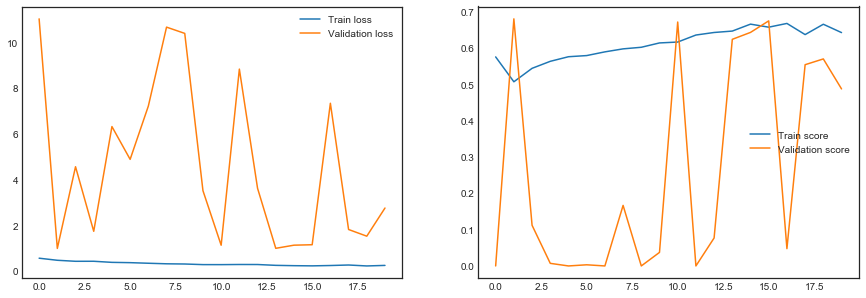

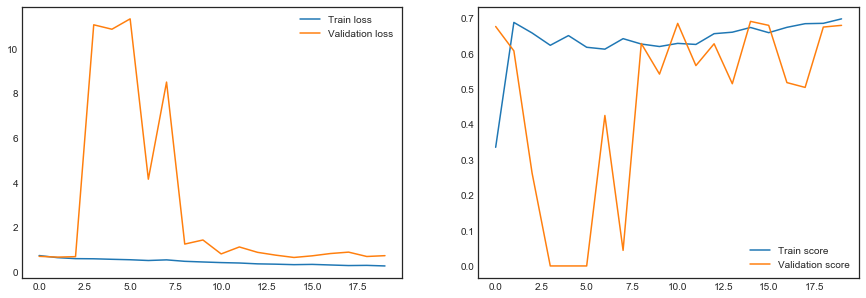

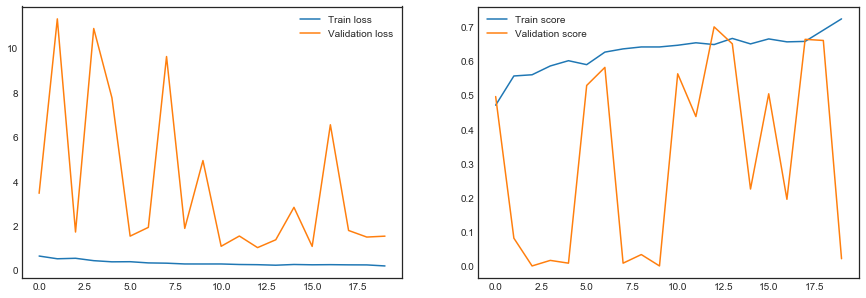

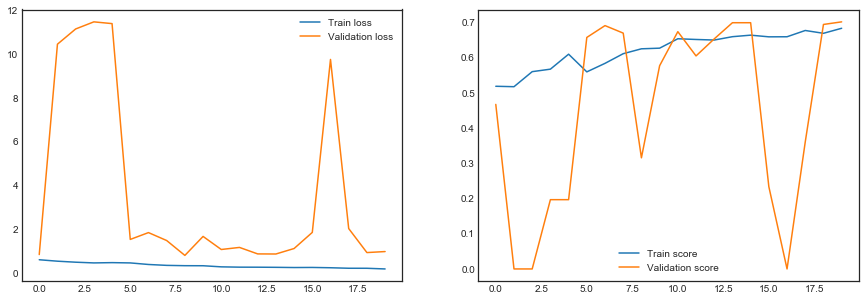

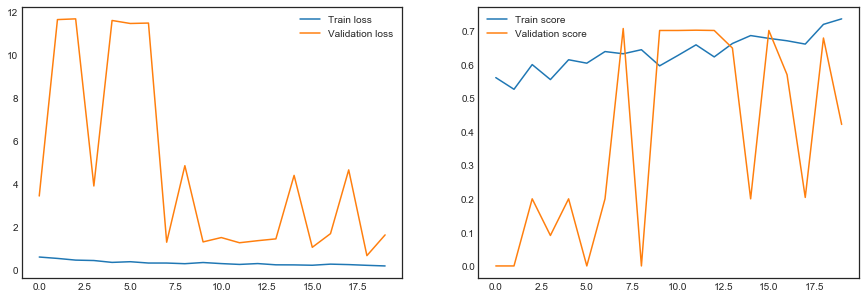

In [15]:
# List to store IoU scores for each CV.
ious = [0] * cv_total

epochs = 20  # small number for demonstration
batch_size = 32
learning_rate = 0.001


for cv_index in range(cv_total):
    # set model names for each CV
    basic_name = f'Unet_resnet_{date}_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    save_model_name = basic_name + '.model'
    
    # train, valid split
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    # Data augmentation (horizontal flip only)
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

    # construct full model
    model = build_compile_model(lr = learning_rate)

    # model ckpt, save model with name "save_model_name"
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
    
    # reduce_lr for future usage
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
                                  factor=0.5, patience=3, min_lr=0.0001, verbose=0)
    
    #list_callbacks = [model_checkpoint, reduce_lr]
    list_callbacks = [model_checkpoint]
    
    # plot fit history
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        #callbacks=[ model_checkpoint,reduce_lr], 
                        callbacks = list_callbacks,
                        shuffle=False,
                        verbose=2)
    plot_history(history,'my_iou_metric')
    
    # load model
    model.load_weights(save_model_name)
    # predict  
    preds_valid = predict_result(model,x_valid,img_size_target)
    # obtain IoU score
    ious[cv_index] = get_iou_vector(y_valid, (preds_valid > 0.5))

# get model summary
model.summary()

In [16]:
# IoU score based on cross entropy loss:
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious = {ious[cv_index]}")

cv 0 ious = 0.6801587301587301
cv 1 ious = 0.6904
cv 2 ious = 0.7065040650406504
cv 3 ious = 0.701639344262295
cv 4 ious = 0.7083333333333334


### 5.3 Second round of training: $\eta_2=0.0005$ with Lovasz hinge as loss <a id="cell_4_3"></a>

Second pass of training with $\eta_2=0.0005$. I use 10 epochs here for demonstration purpose. This time, the loss function is swithed from cross entropy to Lovasz loss.

############################################
 Unet_resnet_0207_v01a_cv1
Train on 980 samples, validate on 126 samples
Epoch 1/10
 - 28s - loss: 0.4970 - my_iou_metric_2: 0.5618 - val_loss: 0.5906 - val_my_iou_metric_2: 0.6786
Epoch 2/10
 - 13s - loss: 0.3171 - my_iou_metric_2: 0.5310 - val_loss: 1.0359 - val_my_iou_metric_2: 0.0262
Epoch 3/10
 - 13s - loss: 0.2607 - my_iou_metric_2: 0.5105 - val_loss: 0.7363 - val_my_iou_metric_2: 0.6778
Epoch 4/10
 - 13s - loss: 0.2635 - my_iou_metric_2: 0.5286 - val_loss: 0.8039 - val_my_iou_metric_2: 0.1619
Epoch 5/10
 - 13s - loss: 0.1774 - my_iou_metric_2: 0.5814 - val_loss: 0.9749 - val_my_iou_metric_2: 0.2206
Epoch 6/10
 - 13s - loss: 0.1992 - my_iou_metric_2: 0.5955 - val_loss: 0.8849 - val_my_iou_metric_2: 0.3016
Epoch 7/10
 - 13s - loss: 0.1365 - my_iou_metric_2: 0.5852 - val_loss: 0.7739 - val_my_iou_metric_2: 0.4873
Epoch 8/10
 - 13s - loss: 0.1144 - my_iou_metric_2: 0.5823 - val_loss: 0.9205 - val_my_iou_metric_2: 0.0675
Epoch 9/10
 - 13s 

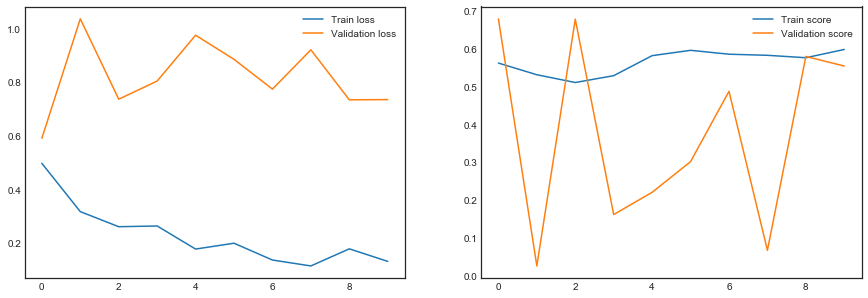

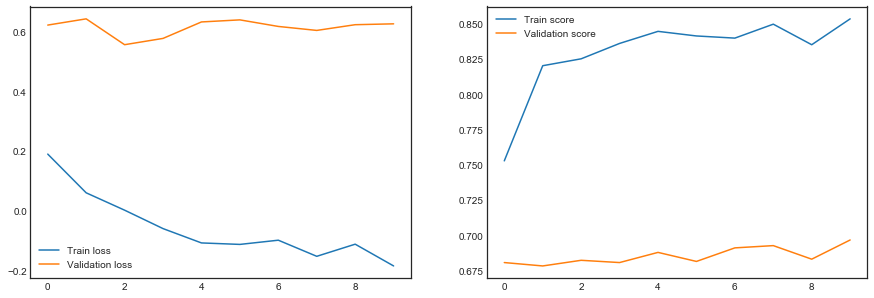

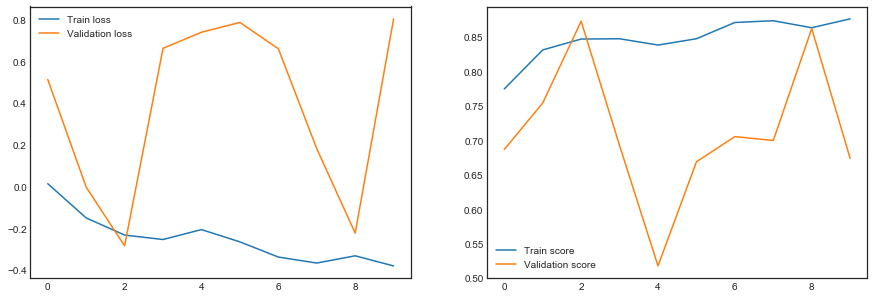

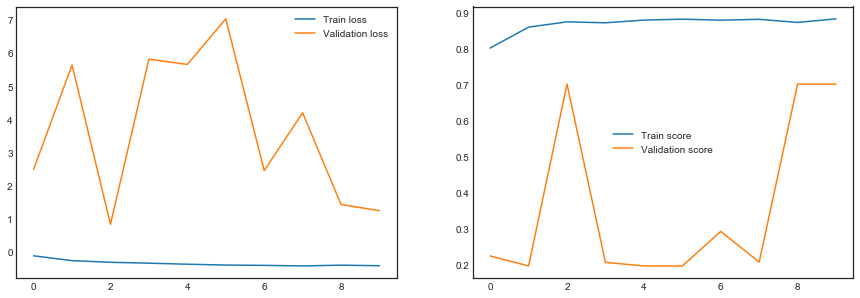

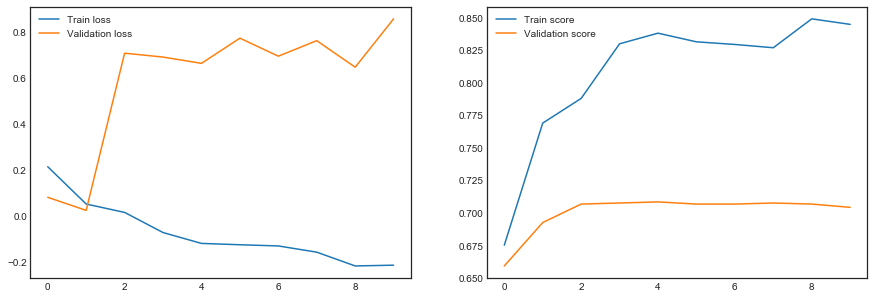

In [17]:
# training with Lovasz loss
ious1 = [0] * cv_total

epochs = 10  # small number for demonstration
batch_size = 32
learning_rate = 0.0005

for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_{date}_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    inp_model_name = basic_name + '.model'
    save_model_name = basic_name + 's.model'
    
    # train, valid split
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    # Data augmentation, flip left-right
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
    
    # load model from previous training
    model1 = load_model(inp_model_name,custom_objects={'my_iou_metric': my_iou_metric})
    
    # remove activation layer and use losvasz loss
    input_x = model1.layers[0].input
    output_layer = model1.layers[-1].input
    model = Model(input_x, output_layer)
    c = optimizers.adam(lr = learning_rate)
    
    # lovasz_loss need input range (-∞，+∞), so remove the last "sigmoid" activation  
    # Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    
    # model ckpt, save model with name "save_model_name"
    model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=0)
    
    # early_stopping (not used) for future implementation
    early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=0)
    
    # reduced learning rate (not used) for future implementation
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=0)

    #list_callbacks = [model_checkpoint, reduce_lr,early_stopping]  # for future usage
    list_callbacks = [model_checkpoint]
    
    # plot fit history
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size, 
                        callbacks=list_callbacks,
                        shuffle=False,
                        verbose=2)
    plot_history(history,'my_iou_metric_2')
    
    # load model
    model.load_weights(save_model_name)
    # make prediction
    preds_valid = predict_result(model,x_valid,img_size_target)
    # get IoUs for each CV
    ious1[cv_index] = get_iou_vector(y_valid, (preds_valid > 0.5))

In [18]:
# IoU score based on Lovasz loss
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious1 = {ious1[cv_index]}")

cv 0 ious1 = 0.6857142857142857
cv 1 ious1 = 0.6944
cv 2 ious1 = 0.8707317073170732
cv 3 ious1 = 0.7008196721311475
cv 4 ious1 = 0.7083333333333334


### 5.4 Third round of training: $\eta_3=0.0001$ with Lovasz hinge as loss <a id="cell_4_4"></a>

Third pass of training with $\eta_3=0.0001$. I use 10 epochs here for demonstration purpose. This time, the loss function is swithed from cross entropy to Lovasz loss.

############################################
 Unet_resnet_0207_v01a_cv1
############################################
 Unet_resnet_0207_v01a_cv1
Train on 980 samples, validate on 126 samples
Epoch 1/10
 - 41s - loss: 0.3086 - my_iou_metric_2: 0.5523 - val_loss: 0.6040 - val_my_iou_metric_2: 0.3595
Epoch 2/10
 - 13s - loss: 0.2542 - my_iou_metric_2: 0.5610 - val_loss: 0.7294 - val_my_iou_metric_2: 0.3635
Epoch 3/10
 - 13s - loss: 0.2208 - my_iou_metric_2: 0.5712 - val_loss: 0.5775 - val_my_iou_metric_2: 0.6738
Epoch 4/10
 - 13s - loss: 0.2164 - my_iou_metric_2: 0.5865 - val_loss: 0.5567 - val_my_iou_metric_2: 0.6770
Epoch 5/10
 - 13s - loss: 0.2202 - my_iou_metric_2: 0.5544 - val_loss: 0.7954 - val_my_iou_metric_2: 0.3786
Epoch 6/10
 - 13s - loss: 0.2332 - my_iou_metric_2: 0.5113 - val_loss: 0.4733 - val_my_iou_metric_2: 0.3460
Epoch 7/10
 - 13s - loss: 0.1850 - my_iou_metric_2: 0.5484 - val_loss: 0.4745 - val_my_iou_metric_2: 0.3397
Epoch 8/10
 - 13s - loss: 0.1706 - my_iou_metric_2: 0.

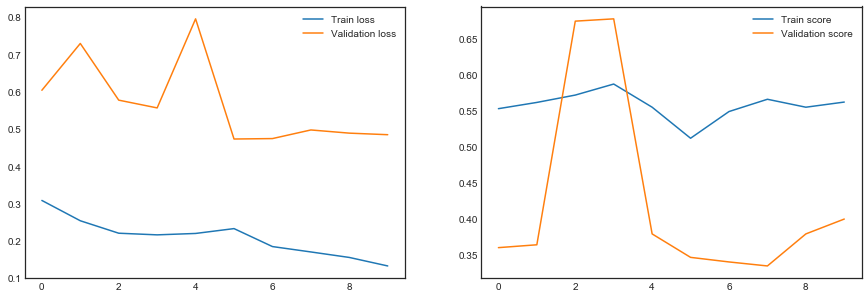

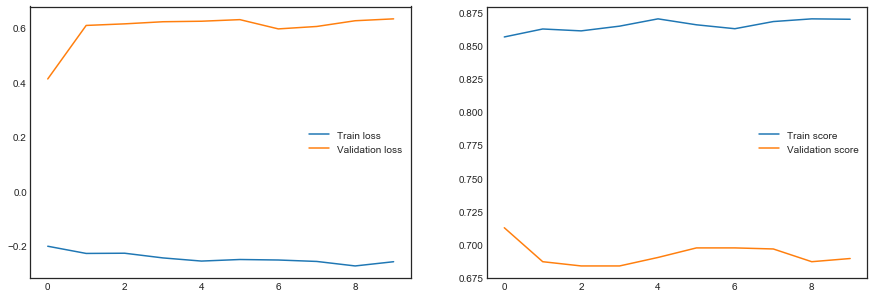

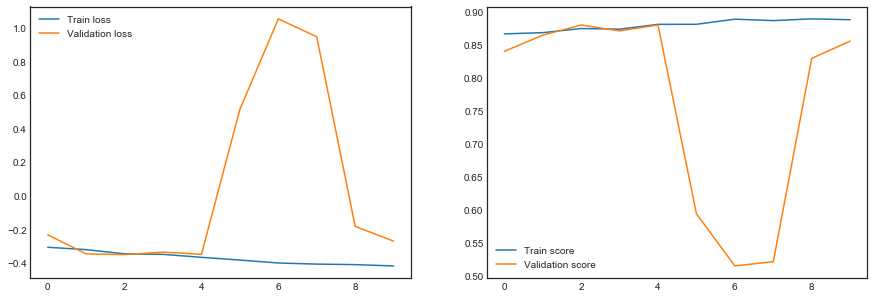

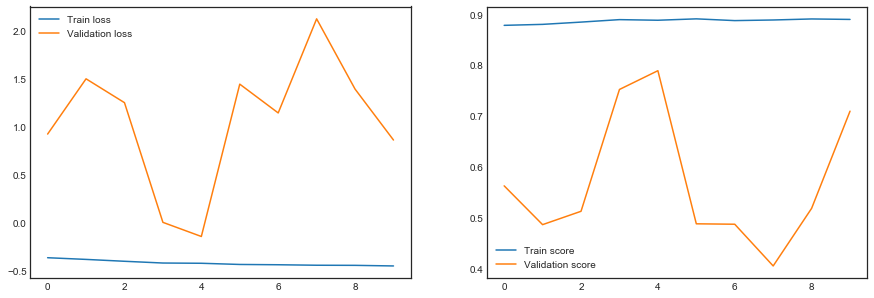

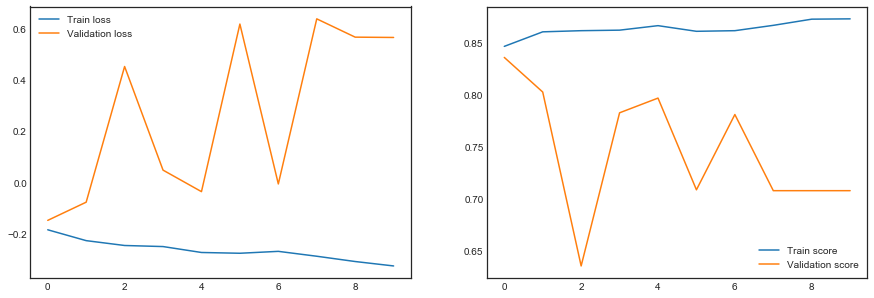

In [19]:
# 3rd training with Lovasz loss
ious3 = [0] * cv_total

epochs = 10  # small number for demonstration
batch_size = 32
learning_rate = 0.0001

for cv_index in range(cv_total):
    # read-in weights from best-trained result (1013_v12_cv?s2.model)
    basic_name1 = f'Unet_resnet_{date}_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name1)
    inp_model_name = basic_name1 + 's.model'
    basic_name2 = f'Unet_resnet_{date}_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name2)
    save_model_name = basic_name2 + 's2.model'
    
    # train, valid split
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    # Data augmentation, flip left/right only
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
    
    # load model from previous training
    model = load_model(inp_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2, 
                                                       'lovasz_loss': lovasz_loss})
    # remove layter activation layer and use losvasz loss
    c = optimizers.adam(lr = learning_rate)
    
    # lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
    # Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
    model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
    
    #early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
    #reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
    
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=0)
        
    # model fit & plot history
    history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[model_checkpoint],
                        shuffle=False,
                        verbose=2)
    plot_history(history,'my_iou_metric_2')
    
    # load model
    model.load_weights(save_model_name)
    # make prediction
    preds_valid = predict_result(model,x_valid,img_size_target)
    # get IoU scores
    ious3[cv_index] = get_iou_vector(y_valid, (preds_valid > 0.5))

In [20]:
# calcuate average ious
def sum_list(items):
    sum_numbers = 0
    for x in items:
        sum_numbers += x
    return sum_numbers

# 2nd round training with New loss
for cv_index in range(cv_total):
    print(f"cv {cv_index} ious3 = {ious3[cv_index]}")
    
print(f"cv avg ious3 = ", sum_list(ious3)/len(ious3))

cv 0 ious3 = 0.6753968253968253
cv 1 ious3 = 0.6935999999999999
cv 2 ious3 = 0.873170731707317
cv 3 ious3 = 0.7836065573770491
cv 4 ious3 = 0.8233333333333335
cv avg ious3 =  0.769821489562905


In [21]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## 6. Result <a id='cell_5'></a>

### 6.1 Load test seismic images <a id="cell_5_1"></a>

Test seismic image is from the third inline.

In [22]:
test_df = pd.read_excel("C:/Users/idrun/Documents/01_DataScience/03_Salt_paper/03_png/test_1113a.xlsx", index_col='id')
x_test = np.array([(np.array(load_img("C:/Users/idrun/Documents/01_DataScience/03_Salt_paper/03_png/tmp_new_1113/images/test/image_{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

Let's load final models and make predictions. The final prediction will be the average of all 5 CV models.

In [23]:
# average the predictions from different folds
t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
for cv_index in range(cv_total):
    basic_name = f'Unet_resnet_{date}_v{version}_cv{cv_index+1}'
    print('############################################\n', basic_name)
    model = load_model(basic_name + 's2.model',custom_objects={'my_iou_metric_2': my_iou_metric_2, 
                                                       'lovasz_loss': lovasz_loss})
    model.load_weights(basic_name + 's2.model')
    preds_test += predict_result(model,x_test,img_size_target) /cv_total
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

############################################
 Unet_resnet_0207_v01a_cv1
############################################
 Unet_resnet_0207_v01a_cv2
############################################
 Unet_resnet_0207_v01a_cv3
############################################
 Unet_resnet_0207_v01a_cv4
############################################
 Unet_resnet_0207_v01a_cv5
Usedtime = 901.8885526657104 s


### 6.2 Save prediction results as numpy array <a id="cell_5_2"></a>

In [24]:
# save preds_test as a file
np.save('preds_test_0207.npy', preds_test)  
preds_test.shape

(308, 101, 101)

### 6.3 Read back predictions and combine <a id="cell_5_3"></a>

In [25]:
# Compatability Imports
from __future__ import print_function
from os.path import isfile, join

import segyio
from os import listdir
import numpy as np
import scipy.misc

from skimage.io import imread, imshow
#from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import pandas as pd

# load in predictions from Yu
preds = np.load('preds_test_1207.npy')  # 
preds.shape

(308, 101, 101)

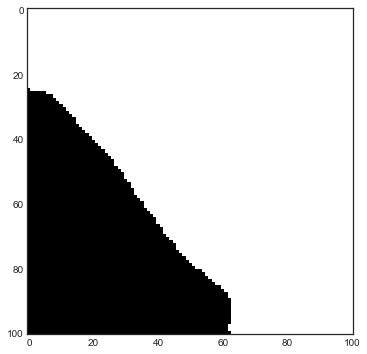

In [26]:
# QC one block image from prediction
# fixed scale after cropping
# preds > 0.45 gets value 0 (non-salt, white)
# preds <= 0.45 gets value 1 (salt, black)

preds1 = np.where(preds>0.45, 0, 1)

plt.figure(num=None, figsize=(12,6))
plt.imshow(preds1[683-616], cmap='gray_r', vmin=0, vmax=1)

In [27]:
# define the function for merging blocks into a full inline
def mergebk(splits):
    mergebk = []

    for i in range(11):
        beg = i * 28
        end = (i+1) * 28
        tmp = splits[beg:end]
        tmp = np.hstack(tmp)
        mergebk.append(tmp)

    mergebk= np.vstack(np.array(mergebk))
    return(mergebk)

In [28]:
# ground truth of the last inline
labels = np.load('labels.npy')    # labels.npy is from upsampling and have values other than 0, 1
labels_cropped = np.where(labels[-308:] > 0.45, 1, 0)  # use threshold to clip values to 0 & 1 only

In [29]:
# fixed scale after cropping
# preds > 0.45 gets value 0 (non-salt, white)
# preds <= 0.45 gets value 1 (salt, black)
preds = np.where(preds>0.45, 0, 1)

### 6.4 Overlay with block information and compare with true labels <a id="cell_5_4"></a>

Let's make some plots to QC the salt body prediction against true interpretation. Note the plots here are created using the model with only 40 epochs training. The results will be significantly imporved with more training epochs, more inputs (including additional augmentations including tilting, rotation, scaling etc..). 

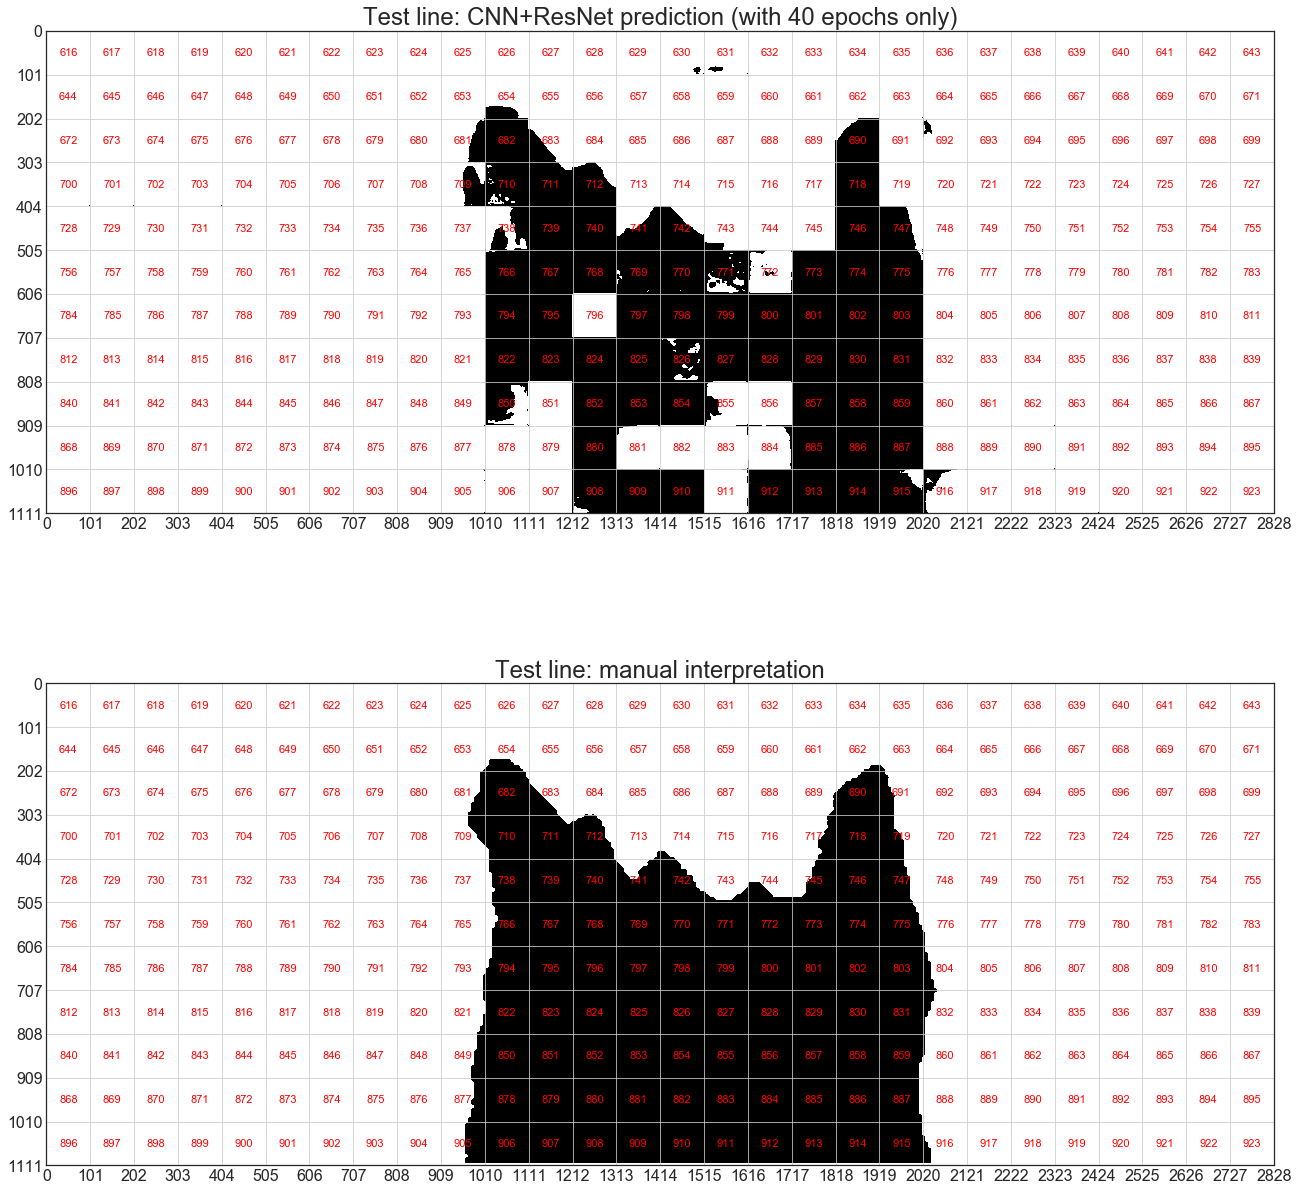

In [30]:
# print with block information
plt.rcParams.update({'font.size':16})
fig, ax = plt.subplots(2, 1, figsize = (22, 22))

import matplotlib.ticker as plticker

myInterval=101
loc_x = plticker.MultipleLocator(base=myInterval)
loc_y = plticker.MultipleLocator(base=myInterval)

# "labels_cropped" is true interpretation
# "preds" is prediction from Deep CNN 
for i, data in enumerate([preds, labels_cropped]):    
    offset = 616  # as for the 3rd inline
    ax[i].xaxis.set_major_locator(loc_x)
    ax[i].yaxis.set_major_locator(loc_y)
    ax[i].grid(which='major', axis='both', linestyle='-')
    if (i!=2):
        ax[i].imshow(mergebk(data), cmap='gray_r', vmin=0, vmax=1)
    if (i==2):
        ax[i].imshow(mergebk(data), cmap='gray_r', vmin=-255, vmax=255)

    # Find number of gridsquares in x and y direction
    nx=abs(int(float(ax[i].get_xlim()[1]-ax[i].get_xlim()[0])/float(myInterval)))
    ny=abs(int(float(ax[i].get_ylim()[1]-ax[i].get_ylim()[0])/float(myInterval)))

    # Add some labels to the gridsquares
    #if (i!=2):
    if (i!=3):
        for j in range(ny):
            y=myInterval/2+j*myInterval
            for k in range(nx):
                x=myInterval/2.+float(k)*myInterval
                ax[i].text(x,y,'{:d}'.format(offset + k+j*nx),color='r',ha='center',va='center', fontsize=11)
        
    
    ax[1].set_title("Test line: manual interpretation", fontsize=24)
    ax[0].set_title("Test line: CNN+ResNet prediction (with 40 epochs only)",fontsize=24)

For comparison, here is the plot shown in my paper after 1000 training epochs ([arXiv:1812.01101](https://arxiv.org/abs/1812.01101)). You can see the salt body prediction accuracy gets improved a lot with more trainings.

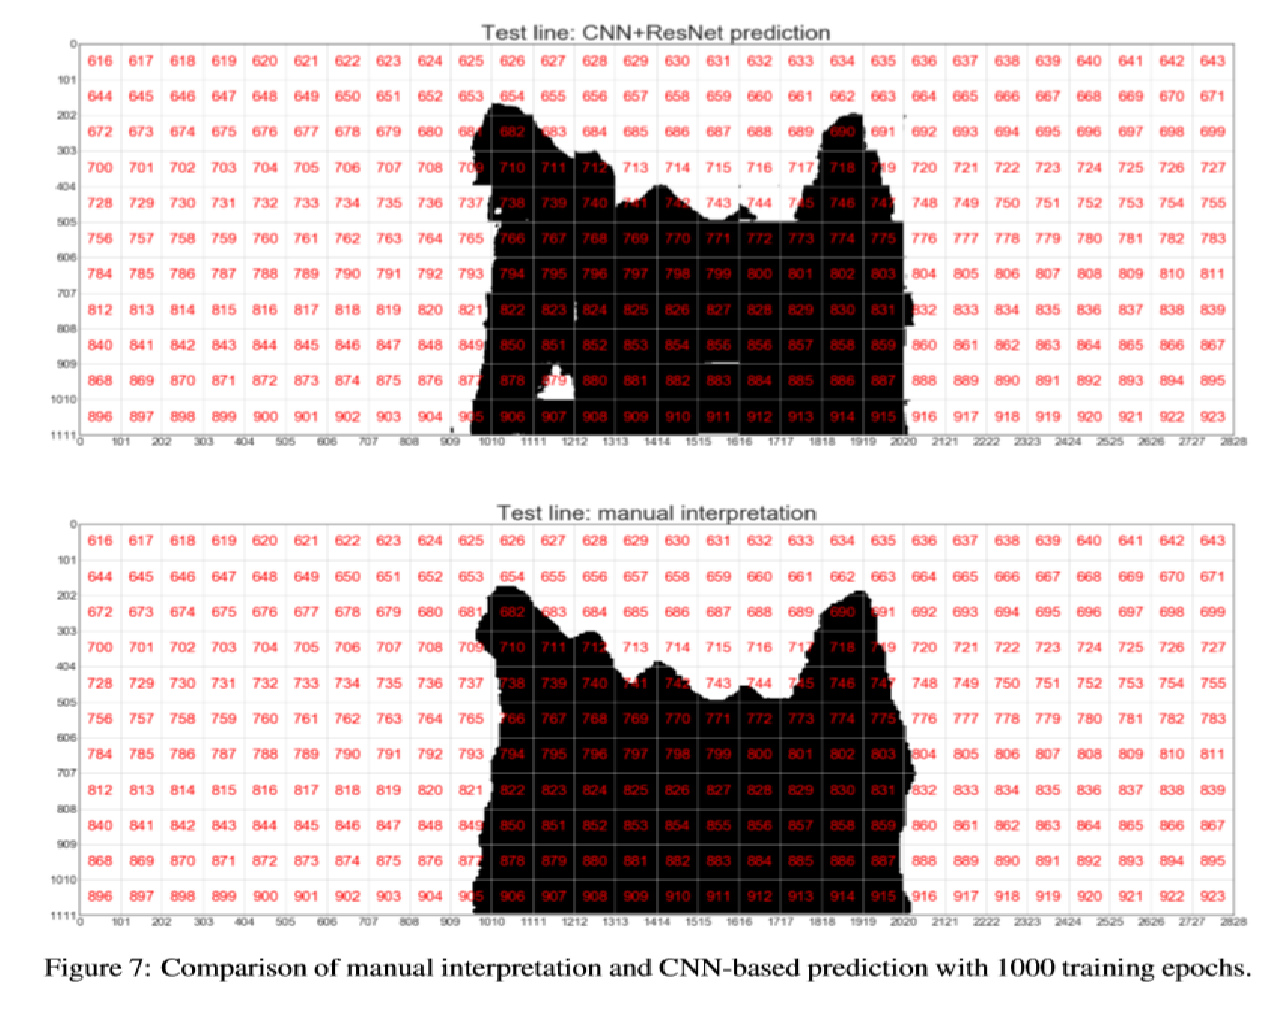

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("Prediction.png")
plt.figure(figsize=(22,18))
plt.imshow(image, aspect='auto')
plt.axis("off")
plt.show()

## 7. Discussion <a id='cell_6'></a>

For the relatively complex CNN architecture we have adopted and given the inputs we already have, we ﬁnd the major improvements are mostly coming from more training epochs. In comparison, though the IoU improvements introduced by using ELU activation function and by using Lov´asz loss function are relatively small (`∼0.002` improvement for each), it is however robust and non-negligible. Ensemble method using stratiﬁed K-fold can further improve the test score by `∼0.015`. 

We would expect more training samples, the usage of pre-trained networks (i.e. ResNet34), and the implementation of snapshot ensemble would further improve the prediction accuracy. To speed up the training process and make the models converge faster, strategy of cyclic learning rate could be adopted to further improve. Another possible way to further improve, is by constructing edge detection related features as additional channel for the CNN. 

At current stage, the CNN-based salt body interpretation is still not perfect and cannot replace manual interpretation. However, the implementation of deep CNNs on seismic data for salt body identiﬁcation is still promising. For example, the rough salt body derived from CNN can be used as input for Full Waveform Inversion without the need to manually interpret a salt body. Another possible application of this CNN-based method would be the real-time feature segmentation.


## 8. Conclusion <a id='cell_7'></a>

We have implemented a deep CNN-based architecture for automatic seismic data salt body interpretation. The network structure is based on U-net plus ResNet using the Adam algorithm. A few improvements, including ELU activation function, Lovasz cost function, stratiﬁed K-fold cross validation and model averaging, have been made to further improve the salt body prediction accuracy. We have demonstrated that salt body can be successfully delineated using seismic data alone in an automatic manner and the prediction result is conﬁrmed to agree well with a manually interpreted salt body.

## Acknowledgements

We would like to thank SEG Advanced Modeling Corporation for providing SEAM data availabe for public usage, and Dr. Haibin Di for providing the training and the testing datasets used for this R & D. 

## Appendix <a id="cell_8"></a>

### A. Model Summary  <a id="cell_8a"></a>

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 101, 101, 16) 160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 101, 101, 16) 64          conv2d_185[0][0]                 
__________________________________________________________________________________________________
activation_185 (Activation)     (None, 101, 101, 16) 0           batch_normalization_181[0][0]    
__________________________________________________________________________________________________
conv2d_186

__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 25, 25, 32)   0           max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, 25, 25, 64)   18496       dropout_34[0][0]                 
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, 25, 25, 64)   256         conv2d_195[0][0]                 
__________________________________________________________________________________________________
activation_195 (Activation)     (None, 25, 25, 64)   0           batch_normalization_191[0][0]    
__________________________________________________________________________________________________
conv2d_196 (Conv2D)             (None, 25, 25, 64)   36928       activation_195[0][0]             
__________

__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 6, 6, 256)    295168      dropout_36[0][0]                 
__________________________________________________________________________________________________
batch_normalization_201 (BatchN (None, 6, 6, 256)    1024        conv2d_205[0][0]                 
__________________________________________________________________________________________________
activation_205 (Activation)     (None, 6, 6, 256)    0           batch_normalization_201[0][0]    
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 6, 6, 256)    590080      activation_205[0][0]             
__________________________________________________________________________________________________
batch_normalization_202 (BatchN (None, 6, 6, 256)    1024        conv2d_206[0][0]                 
__________

concatenate_18 (Concatenate)    (None, 25, 25, 128)  0           conv2d_transpose_18[0][0]        
                                                                 activation_199[0][0]             
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 25, 25, 128)  0           concatenate_18[0][0]             
__________________________________________________________________________________________________
conv2d_215 (Conv2D)             (None, 25, 25, 64)   73792       dropout_38[0][0]                 
__________________________________________________________________________________________________
batch_normalization_211 (BatchN (None, 25, 25, 64)   256         conv2d_215[0][0]                 
__________________________________________________________________________________________________
activation_215 (Activation)     (None, 25, 25, 64)   0           batch_normalization_211[0][0]    
__________

activation_224 (Activation)     (None, 50, 50, 32)   0           batch_normalization_220[0][0]    
__________________________________________________________________________________________________
conv2d_transpose_20 (Conv2DTran (None, 101, 101, 16) 4624        activation_224[0][0]             
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 101, 101, 32) 0           conv2d_transpose_20[0][0]        
                                                                 activation_189[0][0]             
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 101, 101, 32) 0           concatenate_20[0][0]             
__________________________________________________________________________________________________
conv2d_225 (Conv2D)             (None, 101, 101, 16) 4624        dropout_40[0][0]                 
__________

### B. ReLU vs. ELU comparison <a id="cell_8b"></a>

Let's plot ReLU activation function

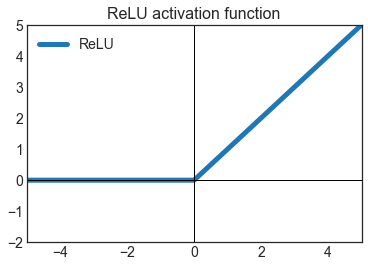

In [33]:
plt.rcParams.update({'font.size':14})

# ========== Generate ReLU function plot  =====================
import pylab
x = np.linspace(-5,5,1000)  # 100 linearly spaced numbers
y = np.linspace(-5,5,1000)

alpha=1
for i in range(len(x)):
    if (x[i]<0):
        y[i] = 0
    else:
        y[i] = x[i]
    #print("i= {}, {}".format(x[i],y[i]))
    
# compose plot
pylab.plot(x,y, linewidth=5.0, label='ReLU')
plt.ylim(-2, 5)
plt.xlim(-5, 5)
plt.axhline(y=0, color='k',linestyle='-',linewidth=1.0)
plt.axhline(y=-1, color='w', linestyle='--')
plt.axvline(x=0, color='k', linestyle='-',linewidth=1.0)
plt.title(r"ReLU activation function", fontsize=16)
plt.legend()

Next, let's plot ELU activation function for comparison:

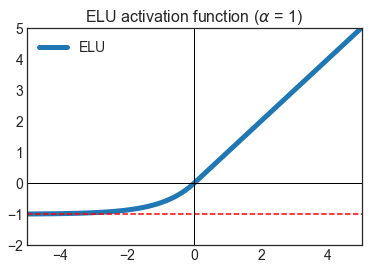

In [34]:
# ========== Generate ELU function plot  =====================
import pylab
x = np.linspace(-5,5,1000)  # 100 linearly spaced numbers
y = np.linspace(-5,5,1000)

alpha=1
for i in range(len(x)):
    if (x[i]<0):
        y[i] = alpha * (np.exp(x[i]) - 1)
    else:
        y[i] = x[i]
    #print("i= {}, {}".format(x[i],y[i]))
    
# compose plot
pylab.plot(x,y, linewidth=5.0, label='ELU')
plt.ylim(-2, 5)
plt.xlim(-5, 5)
plt.axhline(y=0, color='k',linestyle='-',linewidth=1.0)
plt.axhline(y=-1, color='r', linestyle='--')
plt.axvline(x=0, color='k', linestyle='-',linewidth=1.0)
plt.title(r"ELU activation function ($\alpha$ = 1)", fontsize=16)
plt.legend()


Comparing with the ReLU function, the ELU activation function has the following characteristics:
* For x< 0, the ELU has non-zero gradient and thus fix the issue of dying nodes observed in the ReLU function
* ELU is smooth everywhere even at x=0. This may help to speed up the *Gradient Descent* calculation
* Due to its exponential nature, the ELU function is generally slower in computation than the ReLU function and its variants

## Reference

Jones, I. and I. Davison, 2014, Seismic Imaging In and Around Salt Bodies. Interpretation, Vol. 2, No. 4. 

Maniar, H., S. Ryali, M. S. Kulkarni, and A. Abubakar, 2018, Machine Learning Methods in Geoscience. SEG International Exposition and 88th Annual Meeting, page 4638-4642.

Chen, J. and Y. Zeng, 2018, Application of Machine Learning in Rock Facies Classiﬁcation with Physics-Motivated Feature Augmentation, [arXiv:1808.09856](https://arxiv.org/pdf/1808.09856.pdf)

Di,H.,Z.Wang,andG.AlRegib,2018,WhyusingCNNforSeismicInterpretation? AnInvestigation. SEG International Exposition and 88th Annual Meeting, page 2216-2220. 

Abriel, W., 2009, Overview of SEAM Initiative, SEAM workshop presentations: Presented at the 79th Annual International Meeting, SEG. 

Ronneberger, O., P. Fischer, and T. Brox, 2015, U-Net: Convolutional Networks for Biomedical Image Segmentation, [arXiv:1505.04597](https://arxiv.org/pdf/1505.04597.pdf)

He, K., X. Zhang, S. Ren, and J. Sun, 2015, Deep Residual Learning for Image Recognition, [arXiv:1512.03385](https://arxiv.org/pdf/1512.03385.pdf)

He, K., X. Zhang, S. Ren, and J. Sun, 2015, Delving Deep into Rectiﬁers: Surpassing Human-Level Performance on ImageNet Classiﬁcation, [arXiv:1502.01852](https://arxiv.org/pdf/1502.01852.pdf)

Clevert, D., T. Unterthiner, and S. Hochreiter, 2015, Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs), [arXiv:1511.07289](https://arxiv.org/pdf/1511.07289.pdf)

Berman, Maxim and Rannen Triki, Amal and Blaschko, Matthew B., 2018, The Lov´asz-Softmax Loss: A Tractable Surrogate for the Optimization of the Intersection-Over-Union Measure in Neural Networks. The IEEE Conference on Computer Vision and Pattern Recognition (CVPR). 

Goodfellow, I., Bengio,Y., and Courville,A., 2016, Deep Learning. MIT Press 

Waldeland, A. U., A. C. Jensen, L-J. Gelius, and A. H. S. Solberg, 2018, Convolutional Neural Networks for Automated Seismic Interpretation. The Leading Edge, page 529-537. 

Yu, J. and M. B. Blaschko. Learning submodular losses with the Lov´asz hinge. In Proceedings of the 32nd International Conference on Machine Learning, volume 37 of Journal of Machine Learning Research: W&CP , pages 1623-1631, Lille, France, 2015. 

Rakhlin,A.,A.Davydow,andS.Nikolenko,2016,LandCoverClassiﬁcationFromSatelliteImagery With U-Net and Lov´asz-Softmax Loss. The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) 
Workshops. 

GitHub, https://github.com/bermanmaxim/LovaszSoftmax

Kaggle, https://www.kaggle.com/c/tgs-salt-identification-challenge